In [158]:
# import dependencies
%matplotlib inline 
import pandas as pd
import numpy as np
import re
import pprint
import gensim.corpora as corpora
import gensim.models as models
import matplotlib.pyplot as plt

In [159]:
# open text file (~15 annual reports, HTML from annualreports.com)
tmp = open('2014 annuals', 'rb')
tmptmp = " ".join(tmp)
print tmptmp[:100]
print type(tmptmp)

 
 UNITED STATES SECURITIES AND EXCHANGE COMMISSION
 Washington, D.C. 20549
 Form 10-K        
  
 �
<type 'str'>


In [160]:
# create a stoplist for words to be removed 
stoplist = set('for a of the and to in'.split())

In [161]:
# very straightforward text replacement
tmptmp = tmptmp.replace("\n  \n", ". ").strip()
tmptmp = re.sub( '\s+', ' ', tmptmp ).strip()
tmptmp = tmptmp.replace(' .', '.')
tmptmp = tmptmp.replace(' o ', ". ")
# tmptmp[:1000].split('. ')

In [251]:
# turn every line into a string in a list. 
# very basic separator, happening at '. '

texts = [word for word in tmptmp.lower().split('. ') if word not in stoplist]
texts[:20]

['united states securities and exchange commission washington, d.c',
 '20549 form 10-k',
 '\xc3\xbe annual report pursuant to section 13 or 15(d) of the securities exchange act of 1934 for the fiscal year ended december 31, 2014 or',
 'transition report pursuant to section 13 or 15(d) of the securities exchange act of 1934 for the transition period from to commission file number 001-00368 chevron corporation (exact name of registrant as specified in its charter) delaware',
 '94-0890210',
 '6001 bollinger canyon road, san ramon, california 94583-2324 (state or other jurisdiction of incorporation or organization)',
 '(i.r.s',
 'employer identification no.)',
 '(address of principal executive offices) (zip code)',
 'registrant\xe2\x80\x99s telephone number, including area code (925) 842-1000',
 'securities registered pursuant to section 12 (b) of the act:',
 'title of each class',
 'name of each exchange on which registered common stock, par value $.75 per share',
 'new york stock exchang

In [163]:
# remove all special characters, numbers, etc
# i found that special characters tended to dominate the coefficients.

texts2=[]
for i in texts:
    texts2.append(re.sub('[^A-Za-z]+', ' ', i))
texts = texts2
del texts2
print len(texts)

76259


In [164]:
# gensim wants everything to be turned into a dictionary in the tutorial

from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text.split(" "):
        frequency[token] += 1

In [165]:
# again, sloppy written code to remove stopwords from corpus
# and to make a sentence into a list of strings

texts2 = []
for line in texts:
    texts2.append([j for j in line.split(" ") if frequency[j] > 1 and j not in stoplist])
texts = texts2
del texts2

In [166]:
from pprint import pprint
pprint(texts[:1])

[['united',
  'states',
  'securities',
  'exchange',
  'commission',
  'washington',
  'd',
  'c']]


In [199]:
# code to remove all sentence strings that are less than 4 items long

for i in texts:
    if len(i) < 4: 
        texts.remove(i)

In [200]:
# using gensim.corpora to develop a dictionary

dictionary = corpora.Dictionary(texts)
dictionary.save('annualreports.mdl') # store the dictionary, for future reference
print(dictionary)

Dictionary(8533 unique tokens: [u'', u'four', u'woods', u'cyprus', u'localized']...)


In [201]:
# using previous dictionary to fit incoming sentence (new_doc)

new_doc = "currency markets for oil are"
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec) # the word "interaction" does not appear in the dictionary and is ignored
# returns [(token_id, token_count), ...] for incoming sentence

[(281, 1), (417, 1), (426, 1), (587, 1)]


In [202]:
# generate corpus

corpus = [dictionary.doc2bow(text) for text in texts]
# corpora.MmCorpus.serialize('/tmp/deerwester.mm', corpus) # store to disk, for later use

In [203]:
# develop a tfidf stack using the corpus
tfidf = models.TfidfModel(corpus)

In [204]:
print tfidf

TfidfModel(num_docs=57205, num_nnz=701638)


In [205]:
# fitting the corpus into the tfidf we created

corpus_tfidf = tfidf[corpus]

In [206]:
for doc in corpus_tfidf[:5]:
    print(doc)

[(0, 0.3065750480810752), (1, 0.3562708419892729), (2, 0.3129829015322618), (3, 0.33701701564716285), (4, 0.312751658876799), (5, 0.48067925762664876), (6, 0.3074240234412956), (7, 0.3796951178558095)]
[(3, 0.3062684551510486), (4, 0.28421700674724176), (6, 0.279375450983933), (8, 0.040901442944238746), (9, 0.36454840583135417), (10, 0.16376319434980724), (11, 0.32258823765800526), (12, 0.28235698484437616), (13, 0.3062684551510486), (14, 0.2761606109634659), (15, 0.2104271581586034), (16, 0.19730755720376744), (17, 0.2585430637184802), (18, 0.2864869409561377)]
[(3, 0.173787008728944), (4, 0.16127427621671644), (6, 0.15852701485320178), (7, 0.19579450205039073), (11, 0.18304740148990326), (13, 0.173787008728944), (14, 0.1567028066420638), (17, 0.1467060185780207), (18, 0.08128115656592508), (19, 0.2555716918964065), (20, 0.5264663743460074), (21, 0.09036732101119045), (22, 0.1837154833495993), (23, 0.14040895299588343), (24, 0.2342559086678442), (25, 0.1378969710717291), (26, 0.118347

In [236]:
# using the tfidf corpus, and the gensim.corpora.dictionary, develop 500 clusterings
# this is topic modeling

lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=500) # initialize an LSI transformation


In [237]:
# fit corpus_lsi to the lsi model we have generated

corpus_lsi = lsi[corpus_tfidf]

In [238]:
len(corpus_lsi)
# 57205 lines

57205

In [239]:
len(corpus_lsi[1])
# 500 fitted features

500

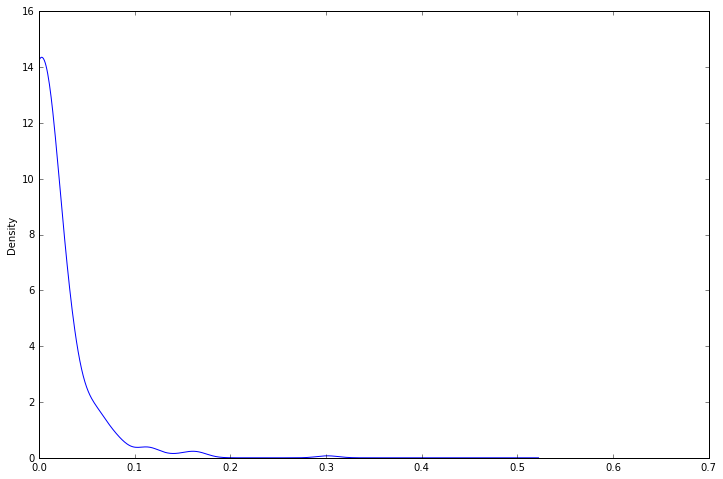

In [240]:
plt.figure(figsize=(12,8))
pd.Series(zip(*corpus_lsi[0])[1]).plot(kind='kde', xlim=(0,0.7))

In [252]:
# how well does sentence 4 fit into each cluster?

corpus_lsi[4][:20]

[(0, 0.074485105691345074),
 (1, 0.030969269572995138),
 (2, 0.023026649631528229),
 (3, -0.014843670324095467),
 (4, -0.0085760952679070097),
 (5, 0.030455909649347329),
 (6, 0.0023190645935189011),
 (7, 0.0087589733578357989),
 (8, 0.10592970284822451),
 (9, 0.032321720875038124),
 (10, 0.12691452812398146),
 (11, 0.0070995551356176217),
 (12, -0.01410586707044063),
 (13, 0.054383968601318104),
 (14, -0.024467020245203142),
 (15, -0.029175973876231595),
 (16, 0.060664531293622689),
 (17, 0.020904821062181562),
 (18, 0.0094956569363603902),
 (19, -0.019282254406907416)]

In [242]:
# creating a dataframe with the above. leaving out blank lines

totalmatr= []
nonemptymatr = []
for idx, i in enumerate(corpus_lsi):
    try:
#         print i[0]
        one, two = zip(*i)
#         print two[:10]
        totalmatr.append(list(two))
        nonemptymatr.append(idx)
    except:
        pass

In [243]:
totalmatrix = pd.DataFrame(totalmatr, index=nonemptymatr)

In [244]:
# visual output of the dataframe

totalmatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000836,0.030002,0.021385,-0.003275,0.014236,0.019394,-0.009774,0.010045,0.051700,0.016715,...,-0.008368,0.011166,-0.014572,-0.007786,-0.002931,0.006768,-0.002908,-0.001166,0.013003,0.002454
1,0.044347,0.217530,-0.210227,-0.091985,-0.000341,0.043265,-0.014792,0.142500,0.034234,0.035283,...,-0.027655,-0.000105,-0.005289,0.000937,-0.009039,0.012174,-0.004684,-0.008800,0.002248,0.019632
2,0.001092,0.077337,0.041162,-0.028745,-0.013941,0.028457,-0.033140,0.024058,0.073720,0.018755,...,-0.003621,-0.008314,-0.002116,0.002921,-0.009264,0.011594,-0.009418,0.014759,0.002032,0.033452
3,0.053813,0.041486,0.036117,0.000928,-0.012586,-0.001213,-0.023136,0.041565,-0.032055,0.046989,...,0.012951,0.014330,-0.003047,0.001956,0.009349,0.003418,-0.006981,-0.006271,-0.008050,0.002660
4,0.074485,0.030969,0.023027,-0.014844,-0.008576,0.030456,0.002319,0.008759,0.105930,0.032322,...,-0.041867,-0.023551,0.019522,0.005294,-0.021600,0.030422,-0.011970,-0.012911,-0.011799,0.025459


In [245]:
totalmatrix[0].idxmax()

5246

In [246]:
# seeing the coefficient of each topic.
# read: 
# ( sentence_id, coefficient*word + coef2*word2 + coef3*word3... )
# the point is to see which words have the most significant pull or push on the topic

lsi.print_topics(10)

[(0,
  u'1.000*"" + 0.007*"total" + 0.007*"december" + 0.006*"income" + 0.005*"net" + 0.005*"other" + 0.004*"ended" + 0.003*"year" + 0.003*"millions" + 0.003*"loss"'),
 (1,
  u'0.295*"december" + 0.238*"ended" + 0.228*"million" + 0.217*"year" + 0.201*"our" + 0.144*"net" + 0.141*"as" + 0.136*"gas" + 0.135*"income" + 0.135*"on"'),
 (2,
  u'-0.494*"december" + -0.491*"ended" + -0.403*"year" + -0.174*"million" + 0.154*"our" + 0.120*"gas" + 0.117*"or" + 0.111*"oil" + -0.104*"years" + 0.095*"are"'),
 (3,
  u'0.534*"total" + 0.508*"income" + 0.324*"net" + 0.192*"loss" + 0.166*"other" + 0.151*"tax" + 0.138*"taxes" + -0.128*"our" + 0.118*"expense" + 0.097*"comprehensive"'),
 (4,
  u'0.718*"total" + -0.382*"income" + -0.214*"net" + 0.194*"gas" + 0.176*"oil" + 0.161*"natural" + -0.155*"loss" + -0.124*"tax" + 0.102*"production" + -0.099*"taxes"'),
 (5,
  u'0.327*"total" + -0.318*"gas" + 0.303*"financial" + 0.295*"consolidated" + 0.289*"statements" + -0.275*"oil" + -0.257*"natural" + 0.237*"notes" 

In [247]:
# this is code to generate top X matches for a specific sentence.

def similar_lsi(string, n_results):
    print string, '\n'
    vec_bow = dictionary.doc2bow(string.lower().split())
    vec_lsi = lsi[vec_bow] # convert the query to LSI space
    index, score = zip(*sorted(vec_lsi, key=lambda tup: tup[1], reverse=True))
    for i in range(n_results):
        print score[i], texts[index[i]], '\n',
    print index[:20]

In [250]:
# similar_lsi(string, n_results):

similar_lsi('the currency exchange of last year was unfavorable for us', 10)

the currency exchange of last year was unfavorable for us 

0.35677452503 ['other', 'americas', ''] 
0.354642459468 ['', 'annual', 'report', 'pursuant', 'section', 'or', 'd', 'securities', 'exchange', 'act', 'fiscal', 'year', 'ended', 'december', 'or'] 
0.303795555471 ['africa', ''] 
0.245456604237 ['reports', 'are', 'also', 'available', 'on', 'sec', 's', 'website', 'at', 'www', 'sec', 'gov'] 
0.232719831146 ['millions', 'cubic', 'feet', 'per', 'day', 'mmcfpd', ''] 
0.228177427315 ['australia', 'oceania', ''] 
0.226956216204 ['changes', 'disagreements', 'with', 'accountants', 'on', 'accounting', 'financial', 'disclosure'] 
0.224630484513 ['unresolved', 'staff', 'comments', ''] 
0.202331604933 ['', 'company', 'holds', 'percent', 'nonoperated', 'working', 'interest', 'heavy', 'oil', 'hebron', 'field', 'also', 'offshore', 'atlantic', 'canada'] 
0.1962222453 ['at', 'december', 'percent', 'company', 's', 'net', 'proved', 'reserves', 'were', 'located', 'kazakhstan', 'percent', 'were', 'locat